### Dataset loader for the deep learning model training.

In [ ]:
import torch
import random
import numpy as np 
from glob import glob
import rasterio as rio 
import geopandas as gpd
from utils.imgShow import imsShow 


In [2]:
dir_scene = 'data/dset/scene/'
dir_dem = 'data/dset/dem/' 
dir_truth = 'data/dset/truth/' 


In [3]:
### secene and truth pairwise data
## traset
ids_tra_gdf = gpd.read_file('data/dset/dset_tra.gpkg')
ids_tra = ids_tra_gdf['id_scene'].tolist()
paths_scene_tra = [dir_scene+id+'_nor.tif' for id in ids_tra]
paths_dem_tra = [dir_dem+id+'_dem_nor.tif' for id in ids_tra]
paths_truth_tra = [dir_truth+id+'.tif' for id in ids_tra] 
## valset
paths_patch_valset = sorted(glob('data/dset/valset/*'))
print(f'train scenes: {len(paths_scene_tra)}, vali patch: {len(paths_patch_valset)}')



train scenes: 48, vali patch: 1959


In [4]:
## create related functions
## - crop scene to patches
class RandomCrop:
    '''
    des: randomly crop corresponding to specific patch size
    '''
    def __init__(self, size=(256, 256)):
        self.size = size
    def __call__(self, image, truth):
        '''size: (height, width)'''
        start_h = random.randint(0, truth.shape[0]-self.size[0])
        start_w = random.randint(0, truth.shape[1]-self.size[1])
        patch = image[:,start_h:start_h+self.size[0],start_w:start_w+self.size[1]]
        truth = truth[start_h:start_h+self.size[0], start_w:start_w+self.size[1]]
        return patch, truth


In [ ]:
### - Dataset definition
class TraSet(torch.utils.data.Dataset):
    def __init__(self, paths_scene, paths_truth, paths_dem=None, path_size=(512, 512)):
        self.paths_scene = paths_scene
        self.paths_truth = paths_truth
        self.paths_dem = paths_dem
        self.path_size = path_size
    def __getitem__(self, idx):
        # Load scene and truth image
        scene_path = self.paths_scene[idx]
        truth_path = self.paths_truth[idx]
        ## 1. read scene and truth images
        with rio.open(scene_path) as src:
            scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)
        with rio.open(truth_path) as truth_src:
            truth_arr = truth_src.read(1)  # (H, W)
        ## 2. read dem
        if self.paths_dem is not None:
            dem_path = self.paths_dem[idx]
            with rio.open(dem_path) as dem_src:
                dem_arr = dem_src.read(1)  # (H, W)
            dem_arr = dem_arr[:, :, np.newaxis]  # expand to (H, W, 1)
            scene_arr = np.concatenate([scene_arr, dem_arr], axis=-1) 
        ## post processing
        scene_arr = scene_arr.astype(np.float32).transpose((2, 0, 1)) # (C, H, W)
        patch, truth = RandomCrop(size=self.path_size)(scene_arr, truth_arr)  # crop
        truth = truth[np.newaxis, :].astype(np.int8)  # (C, H, W)
        patch = torch.from_numpy(patch).float()
        truth = torch.from_numpy(truth).long()
        return patch, truth
    def __len__(self):
        return len(self.paths_scene)

### - Dataset definition
class ValSet(torch.utils.data.Dataset):
    def __init__(self, paths_valset):
        self.paths_valset = paths_valset
    def __getitem__(self, idx):
        ## load valset patch, patch: (H, W, C)
        patch_pdem_ptruth = torch.load(self.paths_valset[idx], weights_only=True) 
        patch_pdem = patch_pdem_ptruth.permute(2,0,1)[0:7]  
        ptruth = patch_pdem_ptruth.permute(2,0,1)[7:]  # (1, H, W)
        return patch_pdem, ptruth
    def __len__(self):
        return len(self.paths_valset)


In [6]:
## Create dataset instances
tra_data = TraSet(paths_scene=list(paths_scene_tra), 
                   paths_truth=list(paths_truth_tra), 
                   paths_dem=list(paths_dem_tra),
                   path_size=(512, 512)
                   )
val_data = ValSet(paths_valset=list(paths_patch_valset)) 


torch.Size([7, 256, 256]) torch.Size([1, 256, 256])
training data size: 48
validation data size: 1959


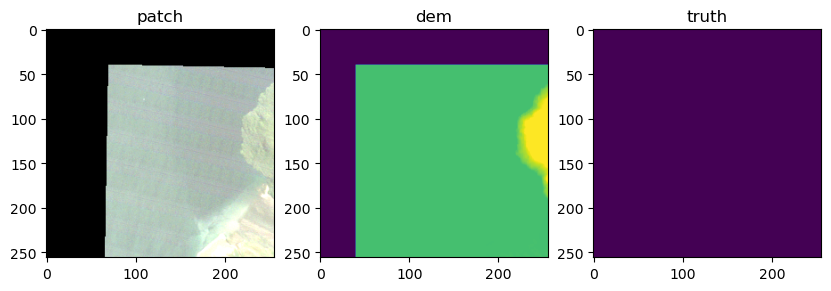

In [7]:
patch_pdem, ptruth = val_data[0]
scene, dem = patch_pdem[:-1], patch_pdem[-1]  # last channel is dem
print(patch_pdem.shape, ptruth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([scene.numpy().transpose((1, 2, 0)), dem.numpy(), ptruth[0].numpy()], 
              clip_list=[2,2,2], img_name_list=['patch','dem','truth'], figsize=(10, 3))


In [7]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


torch.Size([4, 7, 512, 512]) torch.Size([4, 1, 512, 512])


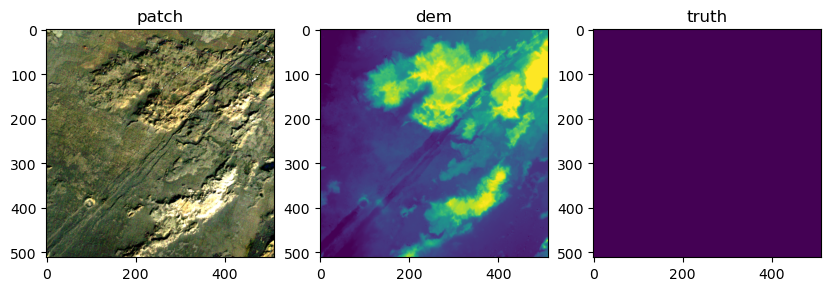

In [8]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_truth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
dem_arr = batch_patch[0].numpy()[-1]
truth_arr = batch_truth[0].numpy().squeeze()
imsShow([patch_arr,  dem_arr, truth_arr],  
          color_bands_list=[[2,1,0], None, None],
          img_name_list=['patch', 'dem', 'truth'], 
          clip_list=[2,2,2], 
          figsize=(10, 3))
